In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
    accuracy_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

plt.rcParams["figure.figsize"] = (8, 5)
pd.set_option("display.max_columns", 100)


In [5]:
# CHANGE this filename if your CSV has a different name
df = pd.read_csv("nba_stats.csv")

df.head()


,Player,Tm,Opp,Res,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,Data
0,Jayson Tatum,BOS,NYK,W,30.30,14,18,0.778,8,11,0.727,1,2,0.500,0,4,4,10,1,1,1,1,37,38.1,2024-10-22
1,Anthony Davis,LAL,MIN,W,37.58,11,23,0.478,1,3,0.333,13,15,0.867,3,13,16,4,1,3,1,1,36,34.0,2024-10-22
2,Derrick White,BOS,NYK,W,26.63,8,13,0.615,6,10,0.600,2,2,1.000,0,3,3,4,1,0,0,1,24,22.4,2024-10-22
3,Jrue Holiday,BOS,NYK,W,30.52,7,9,0.778,4,6,0.667,0,0,0.000,2,2,4,4,1,0,0,2,18,19.5,2024-10-22
4,Miles McBride,NYK,BOS,L,25.85,8,10,0.800,4,5,0.800,2,3,0.667,0,0,0,2,0,0,1,1,22,17.8,2024-10-22


In [6]:
# 1) Filter: keep players with at least 10 games (adjust column name if needed)
df = df[df["G"] >= 10].copy()

# 2) Decide which columns to use (CHANGE names to match your df.columns)
feature_cols = [
    "MP",     # minutes per game
    "FGA",    # field goal attempts per game
    "FG%",    # field goal percentage
    "3PA",    # 3-point attempts per game
    "3P%",    # 3-point percentage
    "FTA",    # free throw attempts per game
    "FT%",    # free throw percentage
    "TRB",    # total rebounds per game
    "AST",    # assists per game
    "STL",    # steals per game
    "BLK",    # blocks per game
    "TOV"     # turnovers per game
]

target_pts_col = "PTS"  # CHANGE if your points per game column has another name

# Keep only those columns + PTS
df = df[feature_cols + [target_pts_col]]

# 3) Handle missing values by simple mean imputation
df = df.fillna(df.mean(numeric_only=True))

df.describe()


KeyError: 'G'

In [7]:
df.columns


Index(['Player', 'Tm', 'Opp', 'Res', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'GmSc', 'Data'],
      dtype='object')

In [8]:
# We skip filtering because there's no games column

# Choose feature columns based on your dataset
feature_cols = [
    "MP",     # minutes played
    "FGA",    # field goal attempts
    "FG%",    # field goal %
    "3PA",    # 3-point attempts
    "3P%",    # 3-point %
    "FTA",    # free throw attempts
    "FT%",    # free throw %
    "TRB",    # total rebounds
    "AST",    # assists
    "STL",    # steals
    "BLK",    # blocks
    "TOV"     # turnovers
]

target_pts_col = "PTS"  # scoring variable

# Keep only features + target
df = df[feature_cols + [target_pts_col]]

# Replace missing numeric values with the mean
df = df.fillna(df.mean(numeric_only=True))

df.describe()
df = df[df["MP"] > 0].copy()


In [9]:
# Drop rows where a player didn't actually play (0 minutes)
df = df[df["MP"] > 0].copy()

# Select useful numeric features for scoring prediction
feature_cols = [
    "MP", "FGA", "FG%", "3PA", "3P%", "FTA", "FT%",
    "TRB", "AST", "STL", "BLK", "TOV"
]

target_pts_col = "PTS"  # Target (points scored in the game)

# Keep only chosen features + target column
df = df[feature_cols + [target_pts_col]]

# Replace missing numeric values
df = df.fillna(df.mean(numeric_only=True))

df.describe()


,MP,FGA,FG%,3PA,3P%,FTA,FT%,TRB,AST,STL,BLK,TOV,PTS
count,16508.000000,16508.000000,16508.000000,16508.000000,16508.000000,16508.000000,16508.000000,16508.000000,16508.000000,16508.000000,16508.000000,16508.000000,16508.000000
mean,22.410688,8.273746,0.427631,3.478798,0.263783,2.017386,0.417838,4.100073,2.454446,0.770172,0.468197,1.274170,10.523443
std,10.892382,6.070804,0.254882,3.151643,0.286277,2.689006,0.435775,3.478488,2.613542,0.991086,0.833446,1.428854,8.829044
min,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14.430000,4.000000,0.286000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,3.000000
50%,23.430000,7.000000,0.444000,3.000000,0.250000,1.000000,0.333000,3.000000,2.000000,0.000000,0.000000,1.000000,9.000000
75%,31.330000,12.000000,0.571000,5.000000,0.500000,3.000000,1.000000,6.000000,4.000000,1.000000,1.000000,2.000000,16.000000
max,50.480000,38.000000,1.000000,20.000000,1.000000,26.000000,1.000000,28.000000,22.000000,8.000000,10.000000,11.000000,60.000000


In [10]:
def scoring_tier(pts):
    if pts < 10:
        return "Low"
    elif pts < 20:
        return "Medium"
    else:
        return "High"

df["tier"] = df[target_pts_col].apply(scoring_tier)

df["tier"].value_counts()


tier
Low       8839
Medium    5023
High      2646
Name: count, dtype: int64

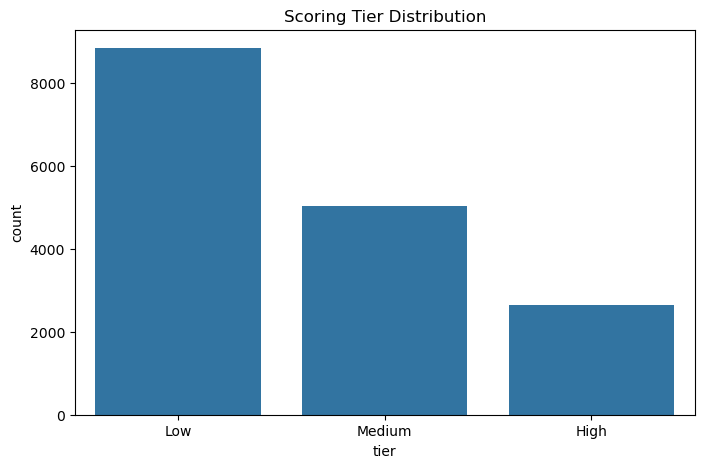

In [11]:
sns.countplot(x="tier", data=df, order=["Low", "Medium", "High"])
plt.title("Scoring Tier Distribution")
plt.show()


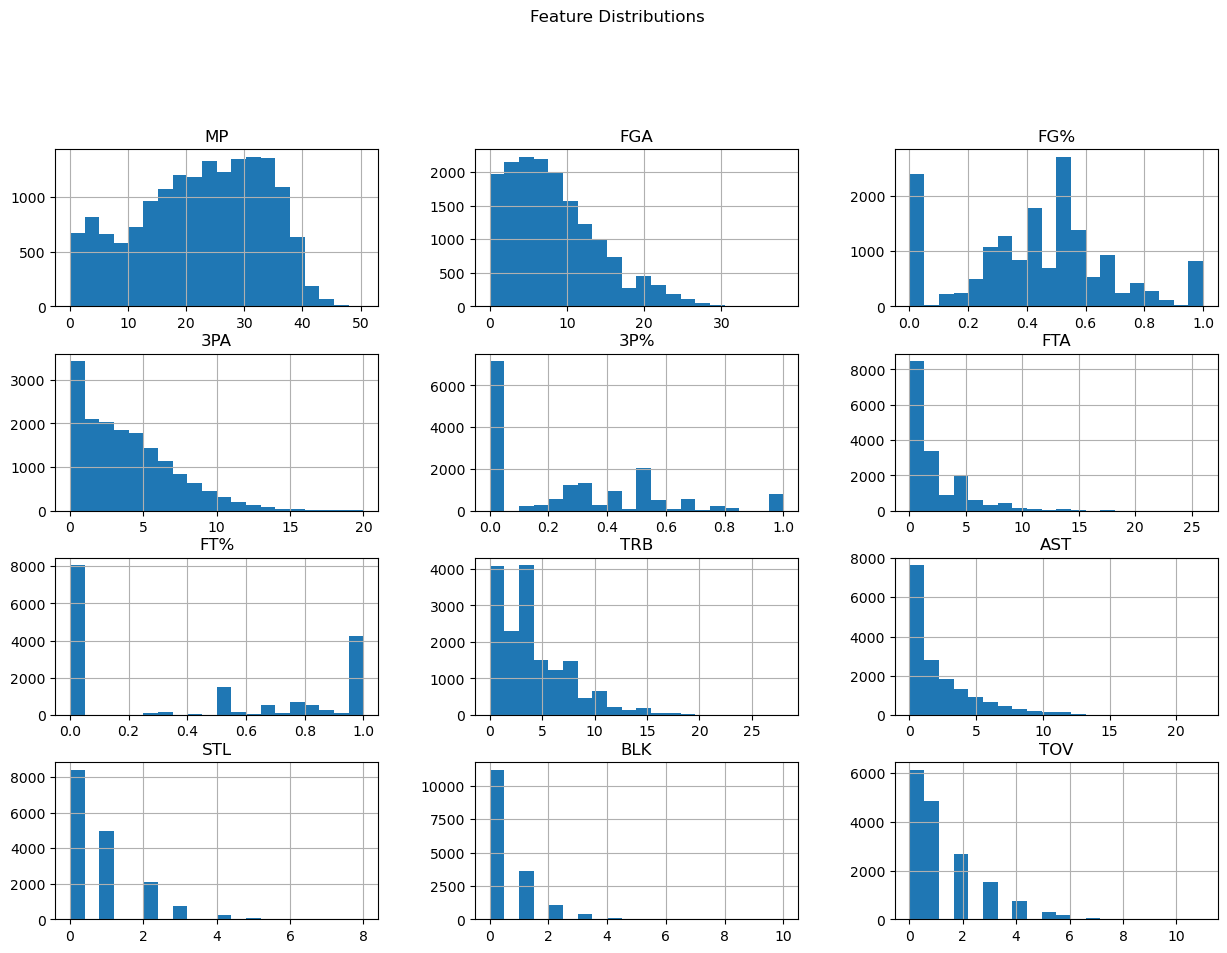

In [12]:
df[feature_cols].hist(bins=20, figsize=(15, 10))
plt.suptitle("Feature Distributions", y=1.02)
plt.show()


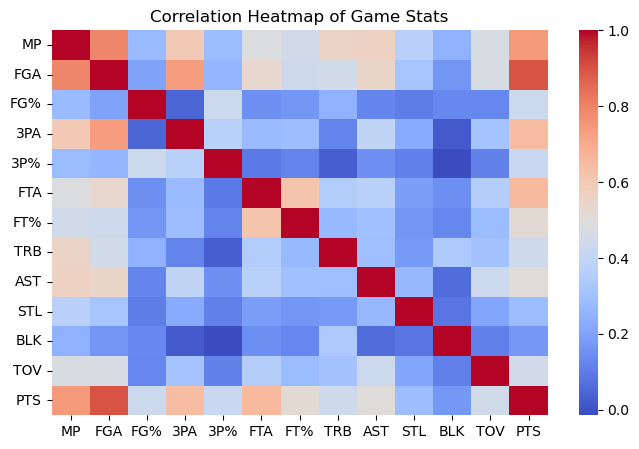

In [13]:
corr = df[feature_cols + [target_pts_col]].corr()
sns.heatmap(corr, cmap="coolwarm")
plt.title("Correlation Heatmap of Game Stats")
plt.show()


In [14]:
X = df[feature_cols]
y = df["tier"]

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.1765, stratify=y_train_full, random_state=42
)

X_train.shape, X_val.shape, X_test.shape


((11554, 12), (2477, 12), (2477, 12))

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


              precision    recall  f1-score   support

        High       0.89      0.95      0.92       397
         Low       0.98      0.94      0.96      1326
      Medium       0.88      0.90      0.89       754

    accuracy                           0.93      2477
   macro avg       0.92      0.93      0.92      2477
weighted avg       0.93      0.93      0.93      2477



/Users/spksmart04/opt/anaconda3/envs/itcs-3156/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


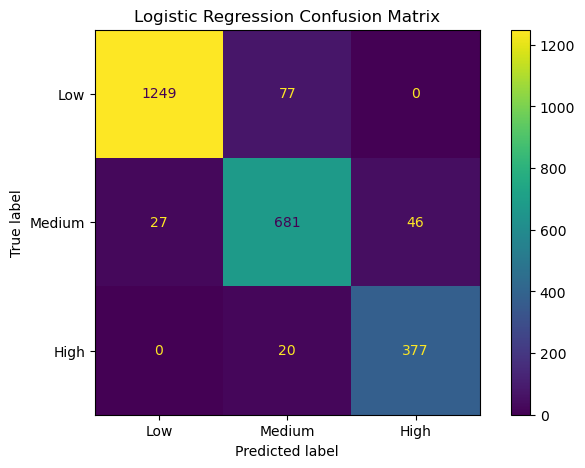

In [16]:
log_reg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=500,
    class_weight="balanced"
)

log_reg.fit(X_train_scaled, y_train)

y_test_pred_lr = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred_lr))

cm_lr = confusion_matrix(y_test, y_test_pred_lr, labels=["Low", "Medium", "High"])
ConfusionMatrixDisplay(cm_lr, display_labels=["Low", "Medium", "High"]).plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()


              precision    recall  f1-score   support

        High       0.96      0.92      0.94       397
         Low       0.99      0.98      0.99      1326
      Medium       0.93      0.96      0.94       754

    accuracy                           0.97      2477
   macro avg       0.96      0.95      0.96      2477
weighted avg       0.97      0.97      0.97      2477



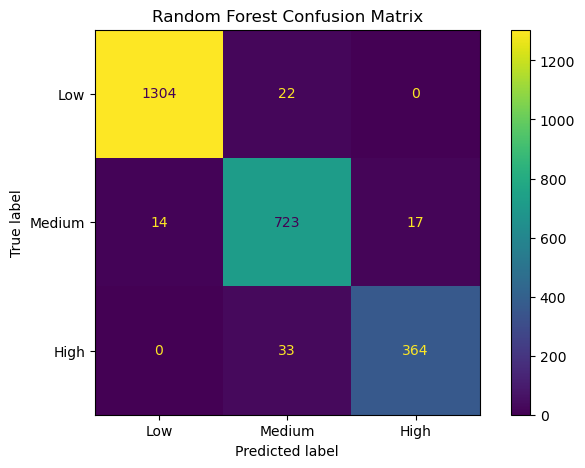

In [17]:
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced", random_state=42
)

rf.fit(X_train, y_train)

y_test_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_test_pred_rf))

cm_rf = confusion_matrix(y_test, y_test_pred_rf, labels=["Low", "Medium", "High"])
ConfusionMatrixDisplay(cm_rf, display_labels=["Low", "Medium", "High"]).plot()
plt.title("Random Forest Confusion Matrix")
plt.show()


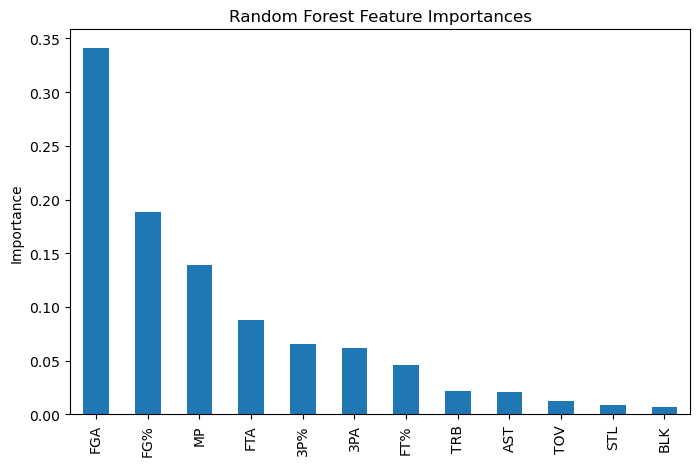

In [18]:
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=False).plot(kind="bar")
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.show()


              precision    recall  f1-score   support

        High       0.98      0.98      0.98       397
         Low       1.00      1.00      1.00      1326
      Medium       0.99      0.99      0.99       754

    accuracy                           0.99      2477
   macro avg       0.99      0.99      0.99      2477
weighted avg       0.99      0.99      0.99      2477



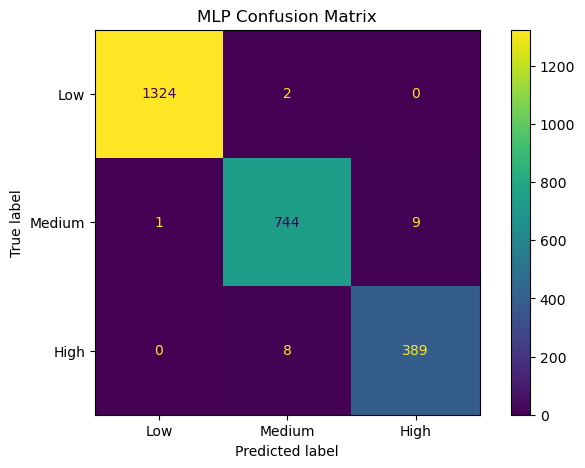

In [19]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=200,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)

y_test_pred_mlp = mlp.predict(X_test_scaled)
print(classification_report(y_test, y_test_pred_mlp))

cm_mlp = confusion_matrix(y_test, y_test_pred_mlp, labels=["Low", "Medium", "High"])
ConfusionMatrixDisplay(cm_mlp, display_labels=["Low", "Medium", "High"]).plot()
plt.title("MLP Confusion Matrix")
plt.show()


In [20]:
def metrics_for(y_true, y_pred, name):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro")
    return pd.Series({"Model": name, "Accuracy": acc,
                      "Macro Precision": prec,
                      "Macro Recall": rec, "Macro F1": f1})

results = pd.DataFrame([
    metrics_for(y_test, y_test_pred_lr, "Logistic Regression"),
    metrics_for(y_test, y_test_pred_rf, "Random Forest"),
    metrics_for(y_test, y_test_pred_mlp, "MLP")
])

results


,Model,Accuracy,Macro Precision,Macro Recall,Macro F1
0,Logistic Regression,0.931369,0.915138,0.931579,0.922859
1,Random Forest,0.965281,0.958021,0.953057,0.955327
2,MLP,0.991926,0.987790,0.988359,0.988074
